# Standard RB Demo

This is a very basic implemention of a standard RB experiment

In [1]:
import numpy as np
import qiskit_experiments as qe
import qiskit.circuit.library as circuits
rb = qe.randomized_benchmarking

# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeParis

backend = AerSimulator.from_backend(FakeParis())

## Running 1-qubit RB

---------------------------------------------------
Experiment: RBExperiment
Experiment ID: 0c479633-2e4c-43d0-a5b2-3e5fd8f1be2b
Status: DONE
Circuits: 140
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.5057410953300154 ± 0.10138262700893501
- alpha: 0.9984200402977647 ± 0.0004323251144779414
- b: 0.48151217431017457 ± 0.10256902101118483
- reduced_chisq: 0.15614332846029255
- dof: 11
- xrange: [1.0, 500.0]
- EPC: 0.0007899798511176725
- EPC_err: 0.00021650462582311876
- success: True


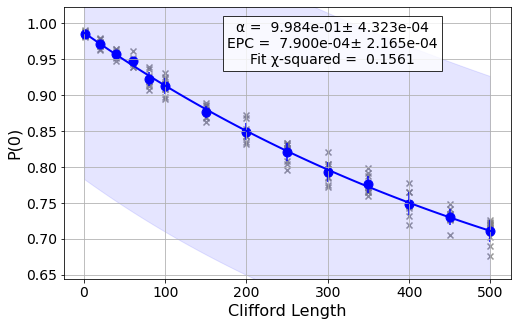

In [2]:
lengths = [1, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]
num_samples = 10
seed = 1010

# Run an RB experiment on qubit 0
exp1 = rb.RBExperiment([0], lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend)

# View result data
print(expdata1)

## Running 2-qubit RB

---------------------------------------------------
Experiment: RBExperiment
Experiment ID: 86835545-046c-4a52-9441-f50c8539a872
Status: DONE
Circuits: 100
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.7086785173869685 ± 0.019061217750847376
- alpha: 0.9682547761398389 ± 0.0016464974131622863
- b: 0.2657588864201139 ± 0.011056874144239694
- reduced_chisq: 0.05584519630538138
- dof: 7
- xrange: [1.0, 200.0]
- EPC: 0.023808917895120824
- EPC_err: 0.001275359637052149
- success: True


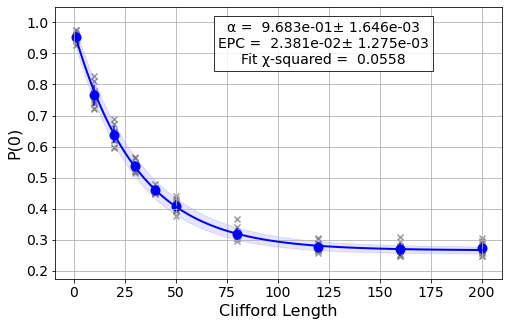

In [3]:
lengths = [1, 10, 20, 30, 40, 50, 80, 120, 160, 200]
num_samples = 10
seed = 1010

# Run an RB experiment on qubits 0, 1
exp2 = rb.RBExperiment([0, 1], lengths, num_samples=num_samples, seed=seed)
expdata2 = exp2.run(backend)

# View result data
print(expdata2)

# Running 1-qubit Interleaved RB

---------------------------------------------------
Experiment: InterleavedRBExperiment
Experiment ID: cec37591-f8db-4058-80ae-e73159463a49
Status: DONE
Circuits: 280
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.46376844067308454 ± 0.037320191722696766
- alpha: 0.9982454199503312 ± 0.00021016356120816523
- alpha_c: 0.9990950045114319 ± 0.00014254329271202085
- b: 0.521986011394672 ± 0.03798556417377216
- reduced_chisq: 0.08737266054671106
- dof: 24
- xrange: [1.0, 500.0]
- EPC: 0.00045249774428407497
- EPC_err: 7.127164635601042e-05
- EPC_systematic_err: 0.0013020823053846997
- EPC_systematic_bounds: [0, 0.0017545800496687747]
- success: True


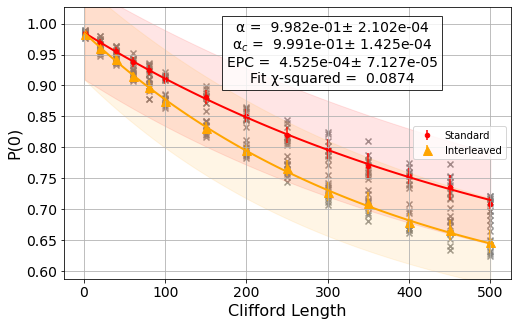

In [4]:
lengths = [1, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]
num_samples = 10
seed = 1010

# Run an RB experiment on qubit 0
int_exp1 = rb.InterleavedRBExperiment(circuits.XGate(), [0], lengths, num_samples=num_samples, seed=seed)
int_expdata1 = int_exp1.run(backend)

# View result data
print(int_expdata1)

# Running 2-qubit Interleaved RB

---------------------------------------------------
Experiment: InterleavedRBExperiment
Experiment ID: 3d9e4cc7-4d19-4fb2-aa03-250502c3fc5c
Status: DONE
Circuits: 200
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.7018166470616463 ± 0.013842937481811897
- alpha: 0.9674076477807713 ± 0.0019613212271226686
- alpha_c: 0.9839420933451414 ± 0.003139693311241397
- b: 0.2634578645861757 ± 0.005672249419711346
- reduced_chisq: 0.13222172753275133
- dof: 16
- xrange: [1.0, 200.0]
- EPC: 0.012043429991143967
- EPC_err: 0.002354769983431048
- EPC_systematic_err: 0.03684509833769914
- EPC_systematic_bounds: [0, 0.048888528328843106]
- success: True


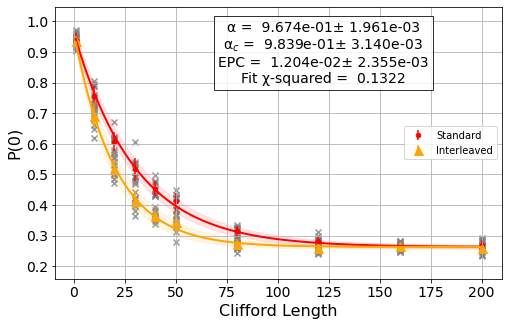

In [5]:
lengths = [1, 10, 20, 30, 40, 50, 80, 120, 160, 200]
num_samples = 10
seed = 1010

# Run an Interleaved RB experiment on qubits 4, 6
int_exp2 = rb.InterleavedRBExperiment(circuits.CXGate(), [4,6], lengths, num_samples=num_samples, seed=seed)
int_expdata2 = int_exp2.run(backend)

# View result data
print(int_expdata2)

## Running parallel RB experiments

---------------------------------------------------
Experiment: ParallelExperiment
Experiment ID: 93a23b0a-de1f-47ce-9cf7-ba02ad92d5df
Status: DONE
Component Experiments: 5
Circuits: 140
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- experiment_types: ['RBExperiment', 'RBExperiment', 'RBExperiment', 'RBExperiment', 'RBExperiment']
- experiment_ids: ['a0fa8768-71cd-40a4-8438-931cdd9b9eea', '48bdf15a-3c8c-4b7f-bdff-87150897fe21', '454d15f5-0455-4d85-abc1-c46f268e0685', 'e7f28773-a077-4bfd-8445-1dd875b56ee7', '08354cff-6a8c-438f-84ee-61d1a2400716']
- experiment_qubits: [(0,), (1,), (2,), (3,), (4,)]
- success: True


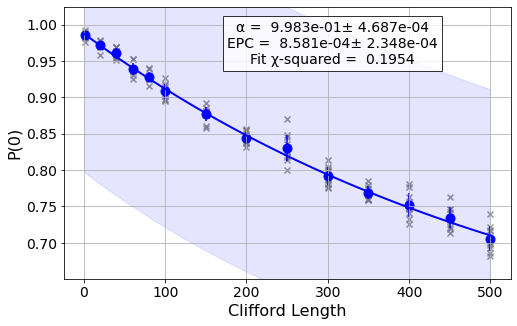

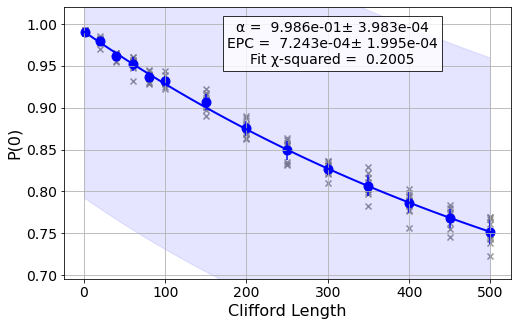

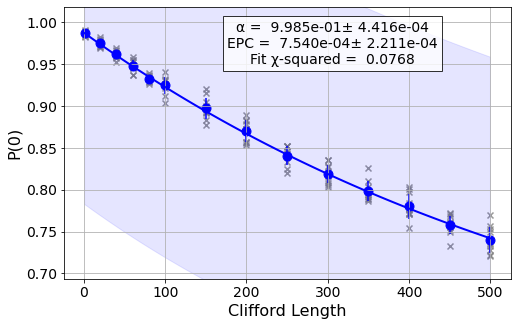

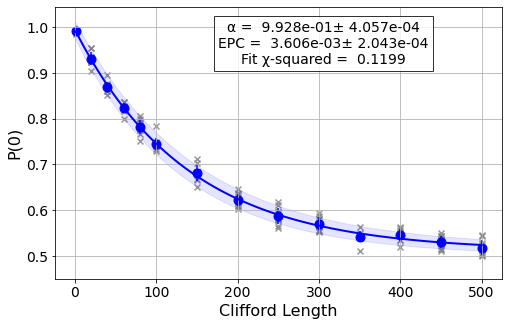

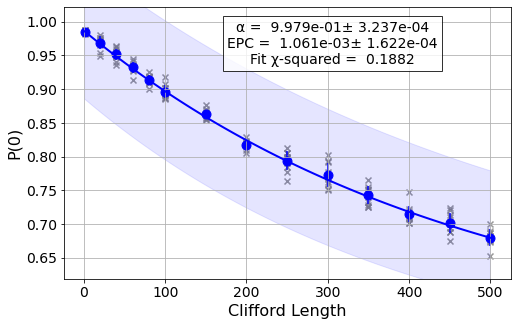

In [6]:
lengths = [1, 20, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500]
num_samples = 10
seed = 1010

exps = [rb.RBExperiment([i], lengths, num_samples=num_samples, seed=seed + i)
        for i in range(5)]

par_exp = qe.composite.ParallelExperiment(exps)
par_expdata = par_exp.run(backend)

# View result
print(par_expdata)

#### Viewing sub experiment data

The experiment data returned from a batched experiment also contains individual experiment data for each sub experiment which can be accessed using `experiment_data(index)`

In [7]:
# Print sub-experiment data
for i in range(par_exp.num_experiments):
    print(par_expdata.component_experiment_data(i), '\n')

---------------------------------------------------
Experiment: RBExperiment
Experiment ID: a0fa8768-71cd-40a4-8438-931cdd9b9eea
Status: DONE
Circuits: 140
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.48179621388397165 ± 0.09442477018477685
- alpha: 0.9982837081083952 ± 0.0004687374781179952
- b: 0.5059960643224992 ± 0.09600953406995398
- reduced_chisq: 0.19535039815566677
- dof: 11
- xrange: [1.0, 500.0]
- EPC: 0.0008581459458024132
- EPC_err: 0.00023477167578252162
- success: True 

---------------------------------------------------
Experiment: RBExperiment
Experiment ID: 48bdf15a-3c8c-4b7f-bdff-87150897fe21
Status: DONE
Circuits: 140
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- a: 0.4644044949493171 ± 0.09896602652728038
- alpha: 0.9985514173179291 ± 0.00039834142468434035
- b: 0.5266142231114757 ± 0.09950372547952774
- reduced_chisq: 0.2004720802914708
- dof: 11
- xrange: [1.0,